In [1]:
# ====== pipsas =======

# implementación
import gymnasium as gym 
import ale_py         
import torch                    
import torch.nn as nn           
import torch.optim as optim     
import numpy as np             
from torch.distributions import Categorical
from torchvision import transforms 

# graficas
import matplotlib.pyplot as plt     

# guardar y cargar 
import os    

In [2]:
# ====== max rendimiento ======

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# ====== normalizar el espacio ======

normaliza = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((84, 84)),
    transforms.ToTensor()
])

def normaliza_frame(frame):
    return normaliza(frame).squeeze(0).numpy()

In [4]:
# ====== actor crítico ======

class ActorC(nn.Module):
    def __init__(self, action_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU()
        )
        self.fc = nn.Linear(64 * 7 * 7, 512)
        self.politica_up = nn.Linear(512, action_dim)
        self.valor_up = nn.Linear(512, 1)

    def forward(self, x):
        x = self.conv(x).view(x.size(0), -1)
        x = torch.relu(self.fc(x))
        return torch.softmax(self.politica_up(x), dim=-1), self.valor_up(x)

In [5]:
# ====== retorno ======

def retorno(rewards, dones, valores, gamma=0.99):
    retornos, G = [], 0
    for r, done, v in zip(reversed(rewards), reversed(dones), reversed(valores)):

        G = r + gamma * G * (1 - done) # función de retorno
        retornos.insert(0, G)

    retornos = torch.tensor(retornos).float().to(device)
    ventajas = retornos - valores
    return retornos, ventajas

In [6]:
# ====== entrenamiento ======

env = gym.make('ALE/Breakout-v5', render_mode=None, frameskip=1)
num_actions = env.action_space.n
print(f"Acciones posibles: {num_actions}")

model = ActorC(num_actions).to(device)
optimizer = optim.Adam(model.parameters(), lr=2.5e-4)

# 🔥 Punto de guardado
check = 'ppo_breakout.pth'
if os.path.exists(check):
    model.load_state_dict(torch.load(check, map_location=device))
    print("✅ Checkpoint cargado.")
else:
    print("🚀 Empezamos entrenamiento desde cero.")

Acciones posibles: 4
✅ Checkpoint cargado.


In [7]:
# ====== datos del entrenamiento ======

episodios = 200
ppo_episodios = 4
batch_size = 2048
gamma = 0.99
clip_eps = 0.1
entropy_coef = 0.01

rewards_h = []

# ====== implementación del entrenamiento ======

for ep in range(episodios):
    states, actions, rewards, dones, log_probs, valores = [], [], [], [], [], []
    obs, _ = env.reset()
    frame = normaliza_frame(obs)
    state_stack = np.stack([frame] * 4, axis=0)
    total_reward = 0

    while len(states) < batch_size:
        state_tensor = torch.FloatTensor(state_stack).unsqueeze(0).to(device)
        probs, value = model(state_tensor)
        dist = Categorical(probs)
        action = dist.sample()
        next_obs, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        next_frame = normaliza_frame(next_obs)
        next_state_stack = np.append(state_stack[1:], [next_frame], axis=0)

        states.append(state_stack)
        actions.append(action.item())
        rewards.append(reward)
        dones.append(float(done))
        log_probs.append(dist.log_prob(action).item())
        valores.append(value.item())
        state_stack = next_state_stack
        total_reward += reward

        if done:
            obs, _ = env.reset()
            frame = normaliza_frame(obs)
            state_stack = np.stack([frame] * 4, axis=0)

    rewards_h.append(total_reward)
    valores_tensor = torch.tensor(valores).float().to(device)
    retornos, ventajas = retorno(rewards, dones, valores_tensor, gamma)
    ventajas = (ventajas - ventajas.mean()) / (ventajas.std() + 1e-8)

    states_tensor = torch.FloatTensor(np.stack(states)).to(device)
    actions_tensor = torch.LongTensor(actions).to(device)
    old_log_probs_tensor = torch.FloatTensor(log_probs).to(device)

    for _ in range(ppo_episodios):
        probs, state_valores = model(states_tensor)
        dist = Categorical(probs)
        new_log_probs = dist.log_prob(actions_tensor)
        ratios = torch.exp(new_log_probs - old_log_probs_tensor)

        surr1 = ratios * ventajas
        surr2 = torch.clamp(ratios, 1 - clip_eps, 1 + clip_eps) * ventajas
        actor_loss = -torch.min(surr1, surr2).mean()
        critic_loss = (state_valores.squeeze() - retornos).pow(2).mean()
        entropy = dist.entropy().mean()
        loss = actor_loss + 0.5 * critic_loss - entropy_coef * entropy

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # guardar cada 25 episodios
    if (ep + 1) % 25 == 0:
        torch.save(model.state_dict(), check)
        print(f"💾 Checkpoint guardado en episodio {ep + 1}")

    print(f"Episodio {ep + 1}, Recompensa total: {total_reward}")

In [8]:
# ====== guardar el último modelo ======

torch.save(model.state_dict(), check)
print("Entrenamiento finalizado y modelo guardado.")

Entrenamiento finalizado y modelo guardado.


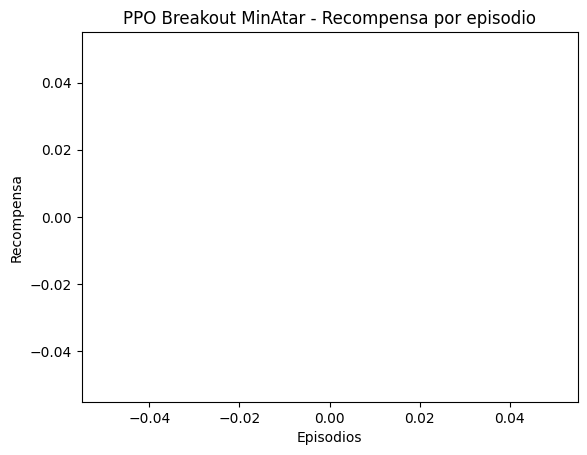

: 

In [ ]:
# ====== grafica de las recompensas ======

plt.plot(rewards_h)
plt.xlabel('Episodios')
plt.ylabel('Recompensa')
plt.title('PPO Breakout MinAtar - Recompensa por episodio')
plt.show()
env.close()


In [ ]:
# Para correr sin necesidad de entrenar ::
env = gym.make('ALE/Breakout-v5', render_mode="human", frameskip=1)
model = ActorC(env.action_space.n).to(device)
model.load_state_dict(torch.load('ppo_breakout.pth', map_location=device))
model.eval()

test_episodes = 5
for ep in range(test_episodes):
    obs, _ = env.reset()
    frame = normaliza_frame(obs)
    state_stack = np.stack([frame] * 4, axis=0)
    total_reward = 0
    done = False

    while not done:
        state_tensor = torch.FloatTensor(state_stack).unsqueeze(0).to(device)
        probs, _ = model(state_tensor)
        action = torch.argmax(probs, dim=1).item()

        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_frame = normaliza_frame(next_obs)
        state_stack = np.append(state_stack[1:], [next_frame], axis=0)
        total_reward += reward

    print(f"Episodio test {ep + 1}, Recompensa total: {total_reward}")

env.close()
